# **Question 1**

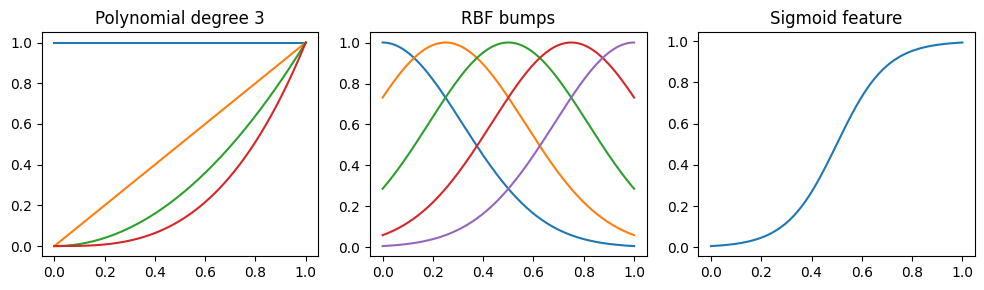

In [2]:
import numpy as np
import matplotlib.pyplot as plt


def poly_features(x, degree):
    """Return polynomial features up to total degree for vector x.
    """
    X = np.asarray(x) # convert to numpy array
    return np.column_stack([x**i for i in range(degree + 1)]) # shape (N, degree + 1)


def rbf_features(x, mus, s):
    """Return Gaussian RBF features with centers mus and precision s.
    """
    X = np.asarray(x)[:, None] # shape (N, 1)
    mus = np.asarray(mus)[None, :] # shape (1, D)
    return np.exp(-s * (X - mus) **2) # shape (N, D)


def sigmoid_features(x, Wrand, brand):
    """Random-feature sigmoids: sigma(Wrand @ x + brand).
    """

    return 1/(1 + np.exp(-(Wrand * x + brand)))


x = np.linspace(0, 1, 200)
plt.figure(figsize=(10,3))
plt.subplot(131); plt.plot(x, poly_features(x,3)); plt.title("Polynomial degree 3")
plt.subplot(132); plt.plot(x, rbf_features(x, mus=np.linspace(0, 1, 5), s=5)); plt.title("RBF bumps")
plt.subplot(133); plt.plot(x, sigmoid_features(x, 10, -5)); plt.title("Sigmoid feature")
plt.tight_layout(); plt.show()


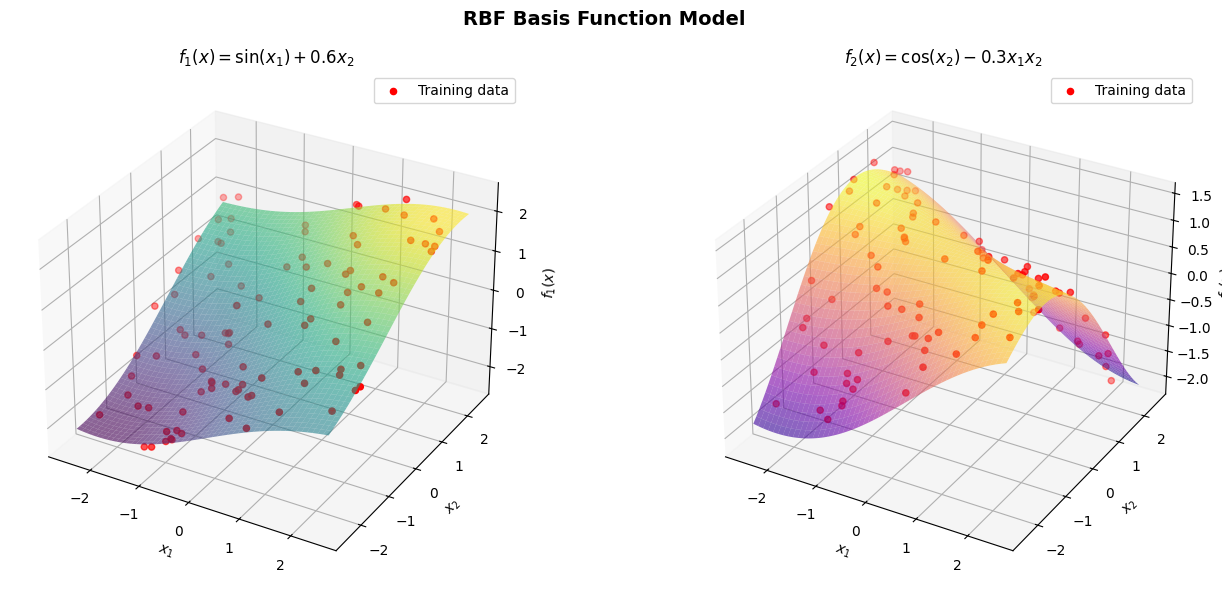


Testing RBF with varying complexity (no ridge)...
Testing rbf with complexity 5, ridge=1e-08...
Testing rbf with complexity 10, ridge=1e-08...
Testing rbf with complexity 15, ridge=1e-08...
Testing rbf with complexity 20, ridge=1e-08...
Testing rbf with complexity 25, ridge=1e-08...
Testing rbf with complexity 30, ridge=1e-08...
Testing rbf with complexity 40, ridge=1e-08...
Testing rbf with complexity 50, ridge=1e-08...


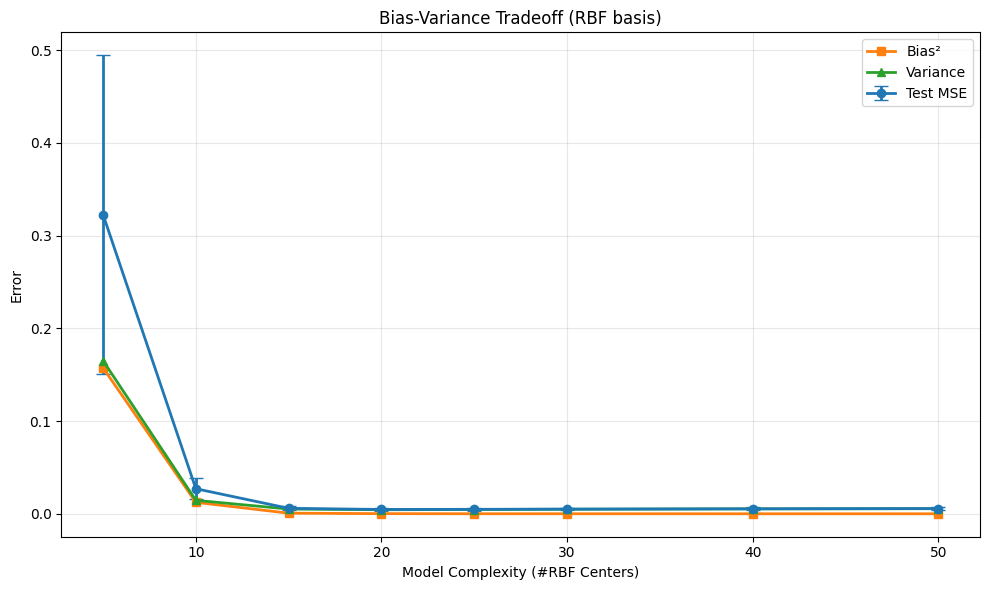


Testing Polynomial with varying degree (no ridge)...
Testing poly with complexity 1, ridge=1e-08...
Testing poly with complexity 2, ridge=1e-08...
Testing poly with complexity 3, ridge=1e-08...
Testing poly with complexity 4, ridge=1e-08...
Testing poly with complexity 5, ridge=1e-08...
Testing poly with complexity 6, ridge=1e-08...


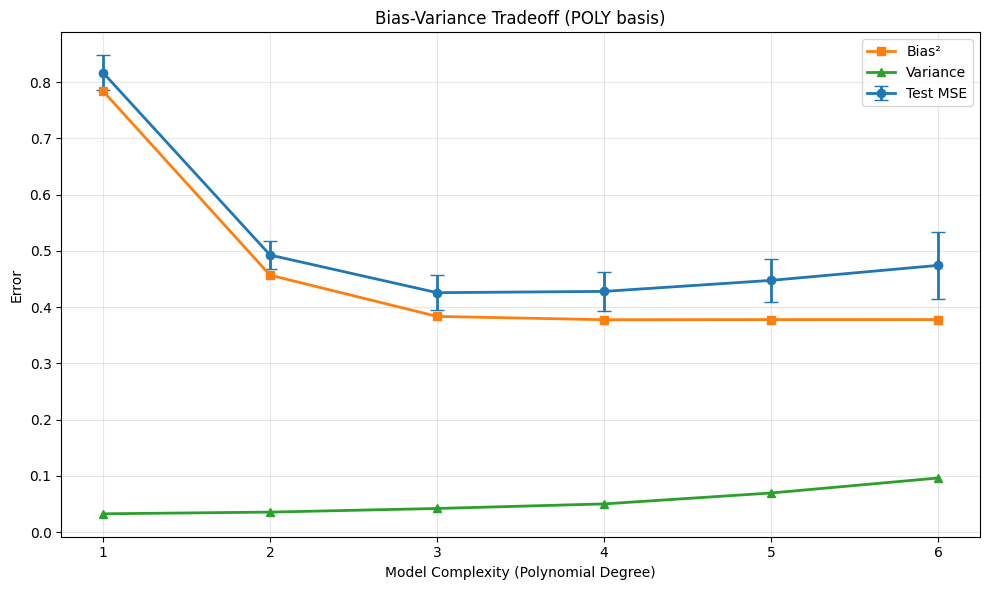


Testing ridge regularization effects...
Testing poly with complexity 6, ridge=1e-08...
Testing poly with complexity 6, ridge=0.001...
Testing poly with complexity 6, ridge=0.01...
Testing poly with complexity 6, ridge=0.1...
Testing poly with complexity 6, ridge=1.0...
Testing poly with complexity 6, ridge=10.0...


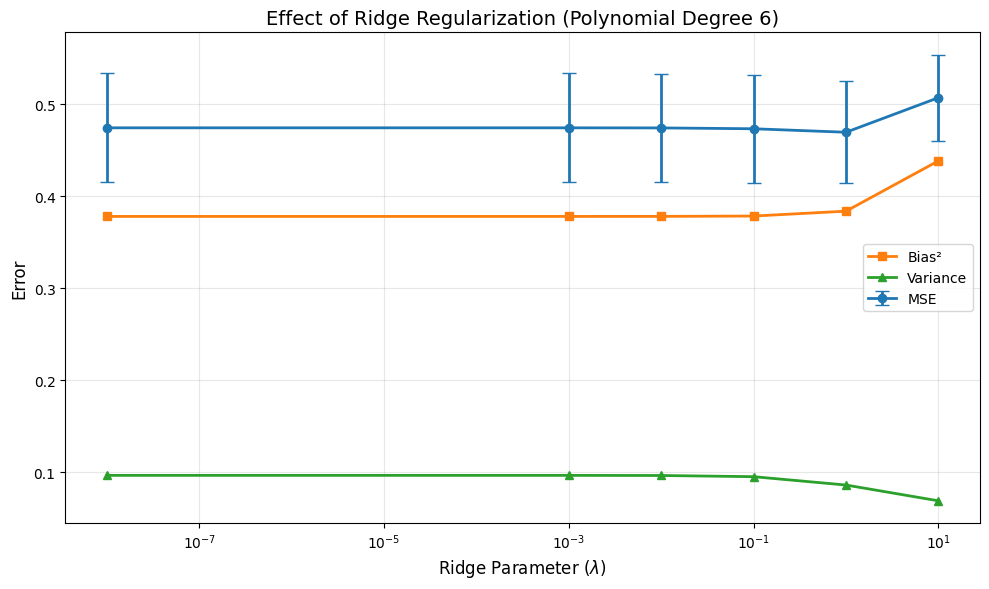

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


class MultioutputRegression:
    def __init__(self, basis="poly", degree=3, num_bases=25, ridge=0.0,
        random_state=0):
        """Store hyperparameters and initialize fitted attributes.
        """
        self.basis = basis
        self.degree = degree
        self.num_bases = num_bases
        self.ridge = ridge
        self.random_state = random_state

        self.Wrand = None # Sigmoid
        self.brand = None # Sigmoid
        self.W = None # Poly
        self.sigma2 = None # Poly
        self.mus = None # RBF
        self.s = None # RBF

        np.random.seed(random_state)

    def _poly_features(self, X):
        """Return for polynomial basis on batch X (N, d).
        X: the shape of the input data
        Returns: array of shape (N, d * (degree + 1))
        """
        N, d = X.shape

        features = [np.ones(N)]
        for i in range(d):
            for j in range(1, self.degree + 1):
                features.append(X[:, i]**j)
        return np.column_stack(features)

    def _rbf_features(self, X):
        """Return for RBF basis; use centers _j and precision s.
        """
        N = X.shape[0]
        M = self.mus.shape[0]

        # Compute RBF features: exp(-s * ||x - mu_j||^2)
        Phi = np.zeros((N, M))
        for j in range(M):
            diff = X - self.mus[j]  # (N, d)
            dist_sq = np.sum(diff**2, axis=1)  # (N,)
            Phi[:, j] = np.exp(-self.s * dist_sq)

        return Phi

    def _sigmoid_features(self, X):
        """Return for sigmoid random features with fixed Wrand, brand.
        """
        Z = X @ self.Wrand.T + self.brand   # (N, num_bases)
        return 1 / (1 + np.exp(-Z))


    def _compute_design(self, X):
        if self.basis == "poly":
            return self._poly_features(X)
        elif self.basis == "rbf":
            return self._rbf_features(X)
        elif self.basis == "sigmoid":
            return self._sigmoid_features(X)
        else:
            raise ValueError("Unknown basis: ’poly’|’rbf’|’sigmoid’.")

    def fit(self, X, T):
        """Fit W via (ridge-)OLS; estimate sigma^2."""
        N, d = X.shape # N = number of samples, d = number of dimensions

        if T.ndim == 1:
            T = T.reshape(-1, 1)
        K = T.shape[1] # K = number of output dimensions

        if self.basis == "rbf":
            # Generate RBF centers
            indices = np.random.choice(N, size=min(self.num_bases, N), replace=False) # random indices to select centers
            self.mus = X[indices]

            # Compute percision using the median distance
            n_samples = min(500, N)
            sample_indices = np.random.choice(N, size=n_samples, replace=False)
            X_sample = X[sample_indices]

            # Compute pairwise distances between samples
            dists = []
            for i in range (n_samples):
                for j in range (i+1, n_samples):
                    dist = np.linalg.norm(X_sample[i] - X_sample[j]) # Euclidean distance
                    dists.append(dist)

            median_dist = np.median(dists)
            self.s = 1 / (2 * median_dist**2) if median_dist > 0 else 1.0 # avoid division by zero

        elif self.basis == "sigmoid":
            self.Wrand = np.random.randn(self.num_bases, d)
            self.brand = np.random.randn(self.num_bases)

        # Compute design matrix
        Phi = self._compute_design(X) # (N, M)
        M = Phi.shape[1] # M = number of basis functions

        A = Phi.T @ Phi + self.ridge * np.eye(M)
        self.W = np.linalg.solve(A, Phi.T @ T)

        predictions = Phi @ self.W
        residuals = T - predictions
        self.sigma2 = np.sum(residuals**2) / (N * K)

        return self

    def predict(self, X):
        if self.W is None:
                raise ValueError("Model not fitted yet.")

        # Compute design matrix
        Phi = self._compute_design(X)  # (N, M)

        # Make predictions
        mean = Phi @ self.W  # (N, K)

        # Return sigma^2 as a vector filled with the scalar estimate
        N = X.shape[0]
        sigma2_vec = np.full((N, 1), self.sigma2)

        return mean, sigma2_vec


# Data generation

def generate_data(N=100, sigma=0.15, seed=42):
    np.random.seed(seed)

    # Sample N points uniformly on [-2.5, 2.5]^2
    X = np.random.uniform(-2.5, 2.5, size = (N, 2))

    # True function
    x1, x2 = X[:, 0], X[:, 1] # x1 and x2 are the coordinates of the points
    f1 = np.sin(x1) + 0.6 * x2
    f2 = np.cos(x2) - 0.3 * (x1 * x2)

    # Stack Outputs
    T_true = np.column_stack([f1, f2])

    # Add gaussian noise
    noise = np.random.normal(0, sigma, size = (N, 2))
    T = T_true + noise

    return X, T, T_true

def plot_data(X, T, model, title = None):

    # Creaing a mesh for plotting

    x1_range = np.linspace(-2.5, 2.5, 50)
    x2_range = np.linspace(-2.5, 2.5, 50)
    X1_mesh, X2_mesh = np.meshgrid(x1_range, x2_range)
    X_mesh = np.column_stack([X1_mesh.ravel(), X2_mesh.ravel()])

    # Predicting on the mesh
    predictions, _ = model.predict(X_mesh)
    F1_mesh = predictions[:, 0].reshape(X1_mesh.shape)
    F2_mesh = predictions[:, 1].reshape(X1_mesh.shape)

    # Creating a figure with two subplots
    fig = plt.figure(figsize=(14, 6))

    # F1 Plot

    ax1 = fig.add_subplot(121, projection='3d')
    ax1.plot_surface(X1_mesh, X2_mesh, F1_mesh, alpha=0.6, cmap='viridis')
    ax1.scatter(X[:, 0], X[:, 1], T[:, 0], c='red', marker='o', s=20, label='Training data')
    ax1.set_xlabel(r'$x_1$')
    ax1.set_ylabel(r'$x_2$')
    ax1.set_zlabel(r'$f_1(x)$')
    ax1.set_title(r'$f_1(x) = \sin(x_1) + 0.6x_2$')
    ax1.legend()

    # F2 Plot
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.plot_surface(X1_mesh, X2_mesh, F2_mesh, alpha=0.6, cmap='plasma')
    ax2.scatter(X[:, 0], X[:, 1], T[:, 1], c='red', marker='o', s=20, label='Training data')
    ax2.set_xlabel(r'$x_1$')
    ax2.set_ylabel(r'$x_2$')
    ax2.set_zlabel(r'$f_2(x)$')
    ax2.set_title(r'$f_2(x) = \cos(x_2) - 0.3x_1x_2$')
    ax2.legend()

    fig.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

X_train, T_train, _ = generate_data(N=100, sigma=0.15)

# Fit RBF model
model_rbf = MultioutputRegression(basis="rbf", num_bases=25, ridge=0.01)
model_rbf.fit(X_train, T_train)

# Visualize
plot_data(X_train, T_train, model_rbf, title="RBF Basis Function Model")


# Bias-Variance Tradeoff

def compute_bias_variance(X_test, T_test_true, model_configs, T=50, N_train=100, sigma=0.15):
    """
    Compute bias-variance tradeoff for different model complexities.

    Args:
        X_test: Fixed test set inputs (N_test, d)
        T_test_true: True noiseless outputs (N_test, K)
        model_configs: List of (basis_type, complexity_param, ridge) tuples
        T: Number of independent training resamples
        N_train: Number of training samples per resample
        sigma: Noise level
    """
    N_test = X_test.shape[0]
    K = T_test_true.shape[1]

    results = []

    for basis, complexity, ridge in model_configs:
        print(f"Testing {basis} with complexity {complexity}, ridge={ridge}...")

        # Store predictions from T different models
        predictions = np.zeros((T, N_test, K))

        for t in range(T):
            # Generate new training data
            X_train, T_train, _ = generate_data(N=N_train, sigma=sigma, seed=t)

            # Fit model
            if basis == 'poly':
                model = MultioutputRegression(basis='poly', degree=complexity, ridge=ridge)
            elif basis == 'rbf':
                model = MultioutputRegression(basis='rbf', num_bases=complexity, ridge=ridge)
            elif basis == 'sigmoid':
                model = MultioutputRegression(basis='sigmoid', num_bases=complexity, ridge=ridge)

            model.fit(X_train, T_train)
            pred, _ = model.predict(X_test)
            predictions[t] = pred

        # Compute average prediction across resamples
        f_bar = np.mean(predictions, axis=0)  # (N_test, K)

        # Compute bias^2 (averaged over test points and outputs)
        bias_squared = np.mean(np.sum((f_bar - T_test_true)**2, axis=1))

        # Compute variance (averaged over test points and outputs)
        variance = 0
        for t in range(T):
            variance += np.mean(np.sum((predictions[t] - f_bar)**2, axis=1))
        variance /= T

        # Compute test MSE
        mse_list = []
        for t in range(T):
            mse = np.mean(np.sum((predictions[t] - T_test_true)**2, axis=1))
            mse_list.append(mse)

        mean_mse = np.mean(mse_list)
        std_mse = np.std(mse_list)

        results.append({
            'basis': basis,
            'complexity': complexity,
            'ridge': ridge,
            'bias_squared': bias_squared,
            'variance': variance,
            'mean_mse': mean_mse,
            'std_mse': std_mse
        })

    return results


def plot_bias_variance(results, basis_type='rbf'):
    """Plot bias-variance tradeoff"""
    # Filter results for specific basis
    filtered = [r for r in results if r['basis'] == basis_type]

    complexities = [r['complexity'] for r in filtered]
    bias_squared = [r['bias_squared'] for r in filtered]
    variance = [r['variance'] for r in filtered]
    mean_mse = [r['mean_mse'] for r in filtered]
    std_mse = [r['std_mse'] for r in filtered]

    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot with error bars
    ax.errorbar(complexities, mean_mse, yerr=std_mse, label='Test MSE',
                marker='o', capsize=5, linewidth=2)
    ax.plot(complexities, bias_squared, label='Bias²', marker='s', linewidth=2)
    ax.plot(complexities, variance, label='Variance', marker='^', linewidth=2)

    ax.set_xlabel('Model Complexity' +
                  (' (Polynomial Degree)' if basis_type == 'poly' else ' (#RBF Centers)'))
    ax.set_ylabel('Error')
    ax.set_title(f'Bias-Variance Tradeoff ({basis_type.upper()} basis)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return fig


# Generate fixed test set (large)
np.random.seed(999)
X_test = np.random.uniform(-2.5, 2.5, size=(500, 2))
x1_test, x2_test = X_test[:, 0], X_test[:, 1]
f1_test = np.sin(x1_test) + 0.6 * x2_test
f2_test = np.cos(x2_test) - 0.3 * x1_test * x2_test
T_test_true = np.column_stack([f1_test, f2_test])

# Test different complexities for RBF (no ridge)
print("\nTesting RBF with varying complexity (no ridge)...")
rbf_configs = [('rbf', n, 1e-8) for n in [5, 10, 15, 20, 25, 30, 40, 50]]
results_rbf = compute_bias_variance(X_test, T_test_true, rbf_configs, T=50, N_train=200)
plot_bias_variance(results_rbf, basis_type='rbf')

# Test polynomial
print("\nTesting Polynomial with varying degree (no ridge)...")
poly_configs = [('poly', d, 1e-8) for d in [1, 2, 3, 4, 5, 6]]
results_poly = compute_bias_variance(X_test, T_test_true, poly_configs, T=30, N_train=100)
plot_bias_variance(results_poly, basis_type='poly')

# Test ridge regularization effects
print("\nTesting ridge regularization effects...")
ridge_values = [1e-8, 0.001, 0.01, 0.1, 1.0, 10.0]
ridge_configs = [('poly', 6, ridge) for ridge in ridge_values]
results_ridge = compute_bias_variance(X_test, T_test_true, ridge_configs, T=30, N_train=100)

# Plot ridge effects
ridge_vals = [r['ridge'] for r in results_ridge]
fig, ax = plt.subplots(figsize=(10, 6))
ax.errorbar(ridge_vals, [r['mean_mse'] for r in results_ridge],
            yerr=[r['std_mse'] for r in results_ridge], label='MSE', marker='o', capsize=5, linewidth=2)
ax.plot(ridge_vals, [r['bias_squared'] for r in results_ridge], label='Bias²', marker='s', linewidth=2)
ax.plot(ridge_vals, [r['variance'] for r in results_ridge], label='Variance', marker='^', linewidth=2)
ax.set_xscale('log')
ax.set_xlabel(r'Ridge Parameter ($\lambda$)', fontsize=12)
ax.set_ylabel('Error', fontsize=12)
ax.set_title('Effect of Ridge Regularization (Polynomial Degree 6)', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



# **Question 2**

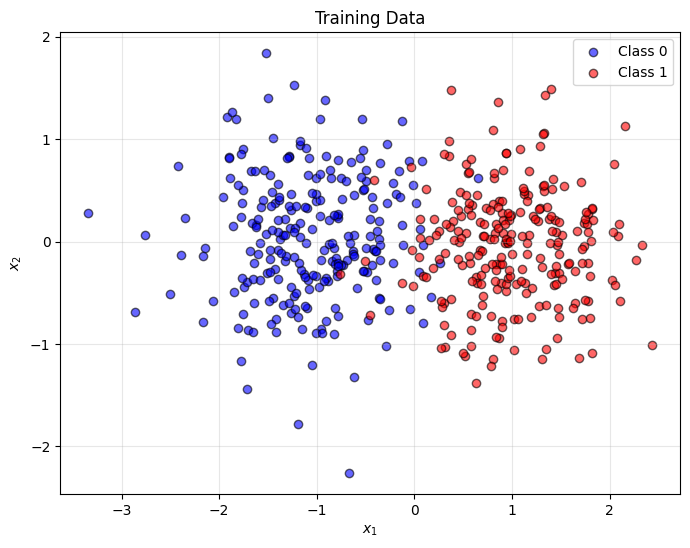

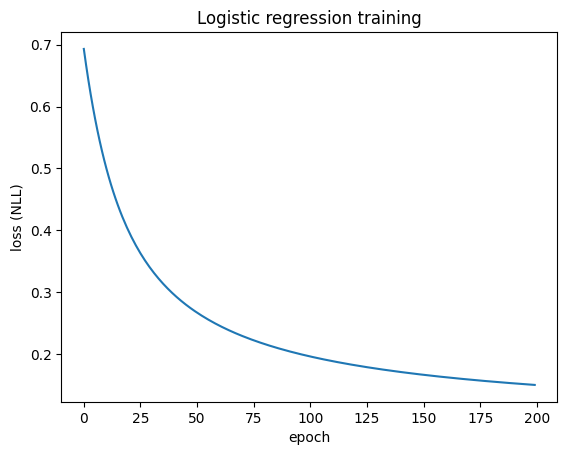

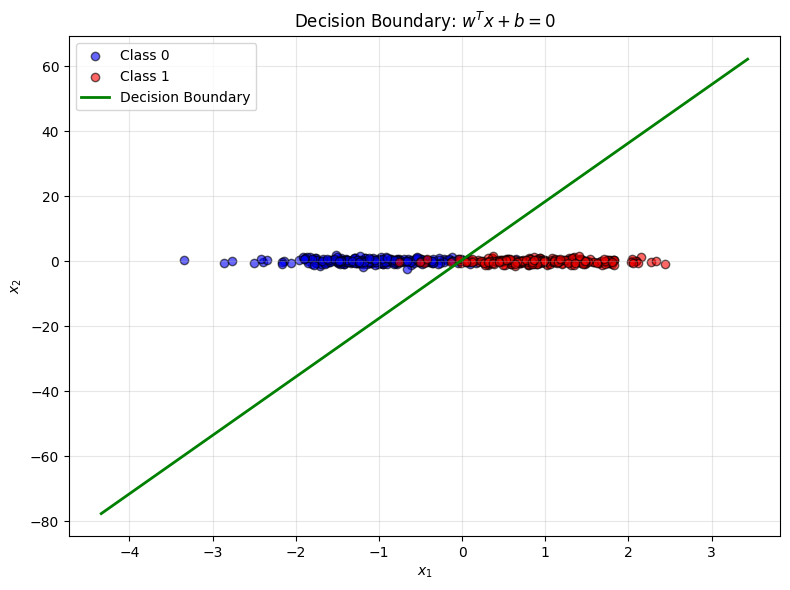

Accuracy: 0.9667
Log-loss: 0.1533
Precision: 0.9828
Recall: 0.9500
F1 score: 0.9661


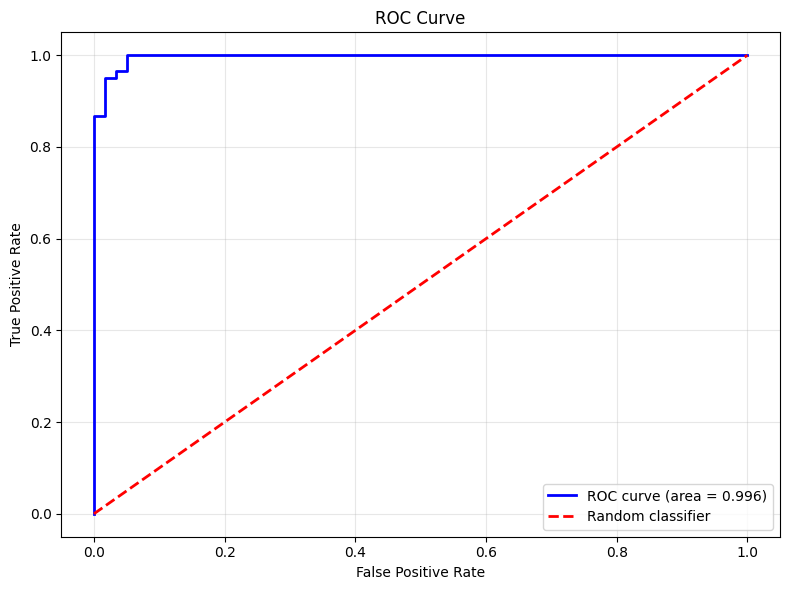

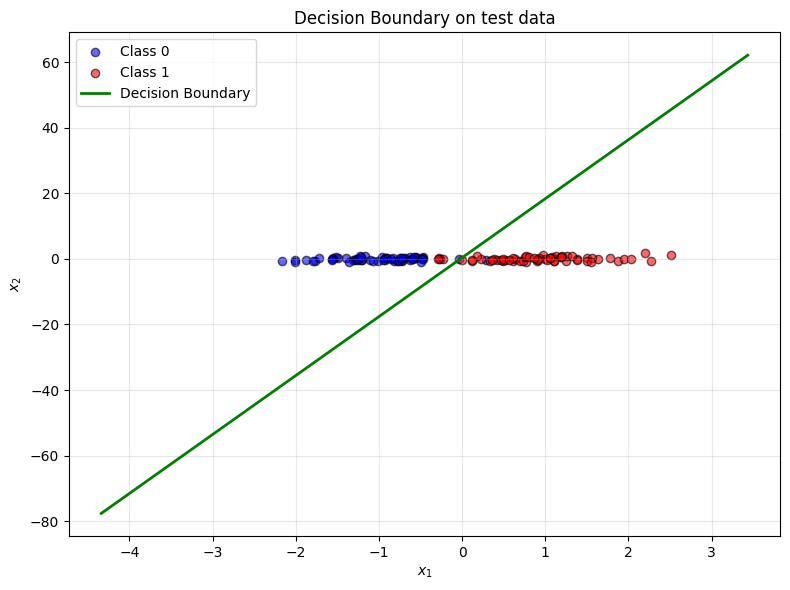

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, log_loss, precision_score, recall_score, f1_score, roc_curve, auc

def make_data(n_per_class=300, seed=0):
    rng = np.random.default_rng(seed) # Random number generator
    mu0 = np.array([-1.0, 0.0])
    mu1 = np.array([1.0, 0.0])
    Sigma = np.diag([0.6**2, 0.6**2])

    X0 = rng.multivariate_normal(mu0, Sigma, size=n_per_class)
    X1 = rng.multivariate_normal(mu1, Sigma, size=n_per_class)

    # Stack the data
    X = np.vstack([X0, X1]) # (2*n_per_class, 2)
    t = np.hstack([np.zeros(n_per_class), np.ones(n_per_class)])
    return X, t

# Generating and plot data
X_train, t_train = make_data(n_per_class=240, seed=0) # 80% of 300 for training
X_test, t_test = make_data(n_per_class=60, seed=42) # 20% of 300 for testing

# Plot data
plt.figure(figsize=(8, 6))
plt.scatter(X_train[t_train==0,0], X_train[t_train==0,1], c='blue', label='Class 0', alpha=0.6, edgecolors='k')
plt.scatter(X_train[t_train==1,0], X_train[t_train==1,1], c='red', label='Class 1', alpha=0.6, edgecolors='k')
plt.xlabel('$x_1$'); plt.ylabel('$x_2$')
plt.title('Training Data'); plt.legend(); plt.grid(True, alpha=0.3)
plt.legend(); plt.show()

def sigmoid(a):
    return 1 / (1 + np.exp(-a))

def loss_and_grad(w, b, X, t):
    """Evaluate loss and gradients for logistic regression.
    X: (N, d)
    t: (N,)
    w: (d,)
    b: scalar
    """
    a = X @ w + b
    yhat = sigmoid(a)

    eps = 1e-12
    L = -np.mean(t * np.log(yhat + eps) + (1 - t) * np.log(1 - yhat + eps))
    diff = (yhat - t)
    grad_w = X.T @ diff / X.shape[0]
    grad_b = np.sum(diff) / X.shape[0]

    return L, grad_w, grad_b

#  Training Loop
X, t = X_train, t_train
N = X.shape[0]
d = X.shape[1]

w = np.zeros(d)
b = 0.0
eta = 0.1
losses = []

for epoch in range(200):
    L, gw, gb = loss_and_grad(w, b, X, t)
    w -= eta * gw
    b -= eta * gb
    losses.append(L)

# Plot loss curve
plt.plot(losses)
plt.xlabel("epoch"); plt.ylabel("loss (NLL)"); plt.title("Logistic regression training");
plt.show()

# Plot decision boundary {z: w^T * x + b = 0}
plt.figure(figsize=(8, 6))
plt.scatter(X[t==0, 0], X[t==0, 1], c='blue', label='Class 0', alpha=0.6, edgecolors='k')
plt.scatter(X[t==1, 0], X[t==1, 1], c='red', label='Class 1', alpha=0.6, edgecolors='k')

# Decision boundary: w[0]*x1 + w[1]*x2 + b = 0  =>  x2 = -(w[0]*x1 + b)/w[1]
x1_range = np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 100)
x2_boundary = -(w[0] * x1_range + b) / w[1]
plt.plot(x1_range, x2_boundary, 'g-', linewidth=2, label='Decision Boundary')

plt.xlabel('$x_1$'); plt.ylabel('$x_2$')
plt.title('Decision Boundary: $w^T x + b = 0$')
plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

# Performance Metrics: ROC curve, accuracy, precision, recall, F1 score
Xtest = X_test
ttest = t_test

# Prediction
y_test = sigmoid(Xtest @ w + b)
pred = (y_test > 0.5).astype(int)

# Metrics
acc = accuracy_score(ttest, pred)
logloss = log_loss(ttest, y_test)
precision = precision_score(ttest, pred)
recall = recall_score(ttest, pred)
f1 = f1_score(ttest, pred)

print(f"Accuracy: {acc:.4f}")
print(f"Log-loss: {logloss:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 score: {f1:.4f}")

# ROC curve
fpr, tpr, thresholds = roc_curve(ttest, y_test) # True positive rate vs false positive rate
roc_auc = auc(fpr, tpr) # Area under the curve

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0,1], [0,1], 'r--', linewidth=2, label='Random classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

# Decision boundary for test data
plt.figure(figsize=(8, 6))
plt.scatter(Xtest[ttest==0, 0], Xtest[ttest==0, 1], c='blue', label='Class 0', alpha=0.6, edgecolors='k')
plt.scatter(Xtest[ttest==1, 0], Xtest[ttest==1, 1], c='red', label='Class 1', alpha=0.6, edgecolors='k')
plt.plot(x1_range, x2_boundary, 'g-', linewidth=2, label='Decision Boundary')
plt.xlabel('$x_1$'); plt.ylabel('$x_2$')
plt.title('Decision Boundary on test data')
plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

# **Question 3**

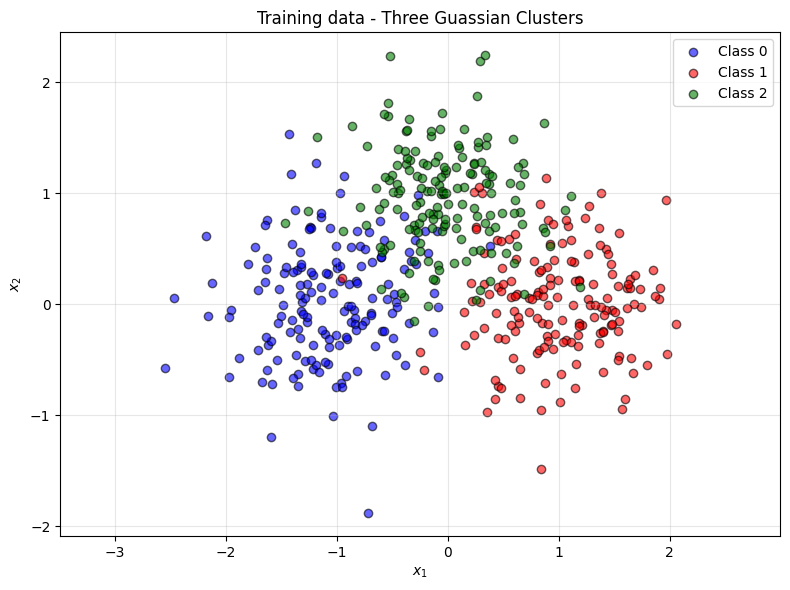


Small logits: [[1. 2. 3.]]
Naive:   [[0.09003057 0.24472847 0.66524096]]
Stable:  [[0.09003057 0.24472847 0.66524096]]

Large logits: [[1000. 1001. 1002.]]
Naive:   [[nan nan nan]] Contains NaN/inf
Stable:  [[0.09003057 0.24472847 0.66524096]] Working

Logits:
 [[1.  2.  3. ]
 [0.5 1.5 2.5]]

log(softmax(A)) - direct method:
 [[-2.40760596 -1.40760596 -0.40760596]
 [-2.40760596 -1.40760596 -0.40760596]]

log_softmax(A) - stable method:
 [[-2.40760596 -1.40760596 -0.40760596]
 [-2.40760596 -1.40760596 -0.40760596]]

Difference (should be ~0):
 [[4.44089210e-16 0.00000000e+00 5.55111512e-17]
 [4.44089210e-16 0.00000000e+00 5.55111512e-17]]
Max difference: 4.440892098500626e-16
Training with Stable Softmax:
Epoch   0: Loss = 1.0986
Epoch  50: Loss = 0.3274
Epoch 100: Loss = 0.2954


/tmp/ipython-input-2040656137.py:44: RuntimeWarning: overflow encountered in exp
  expA = np.exp(A)
/tmp/ipython-input-2040656137.py:45: RuntimeWarning: invalid value encountered in divide
  return expA / np.sum(expA, axis=1, keepdims=True)


Epoch 150: Loss = 0.2852
Epoch 199: Loss = 0.2806
{'Training with Log sum exp'}
Epoch   0: Loss = 1.0986
Epoch  50: Loss = 0.3274
Epoch 100: Loss = 0.2954
Epoch 150: Loss = 0.2852
Epoch 199: Loss = 0.2806


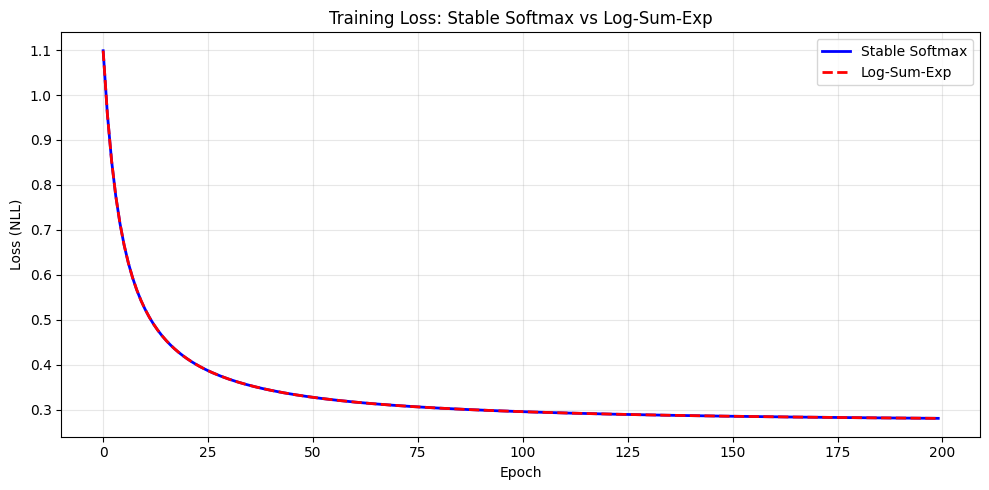

Final loss (stable):  0.280624
Final loss (logsumexp): 0.280624
Difference: 2.24e-12
W difference: 5.00e-16
b difference: 1.94e-16
Accuracy: 0.9250

Confusion Matrix:
[[39  1  0]
 [ 0 39  1]
 [ 5  2 33]]

Per-class Metrics:
Class 0: Precision=0.886, Recall=0.975, F1=0.929
Class 1: Precision=0.929, Recall=0.975, F1=0.951
Class 2: Precision=0.971, Recall=0.825, F1=0.892


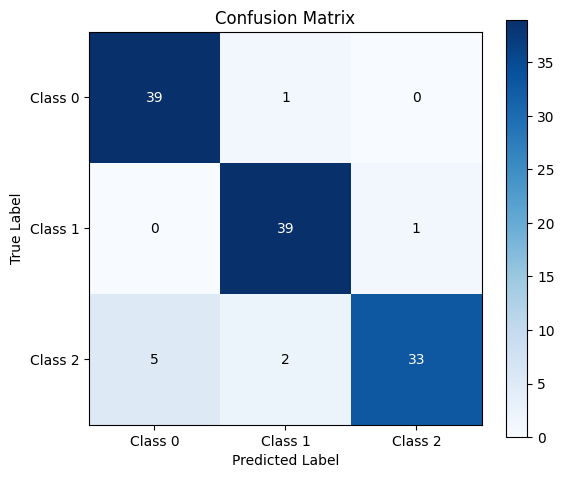

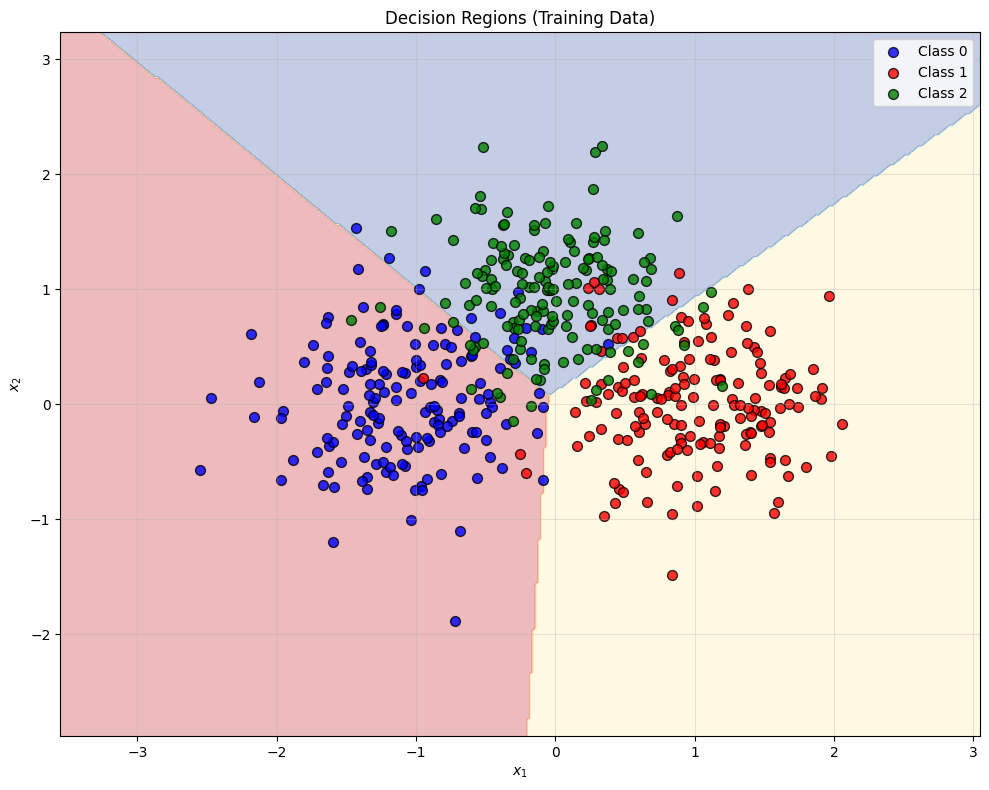

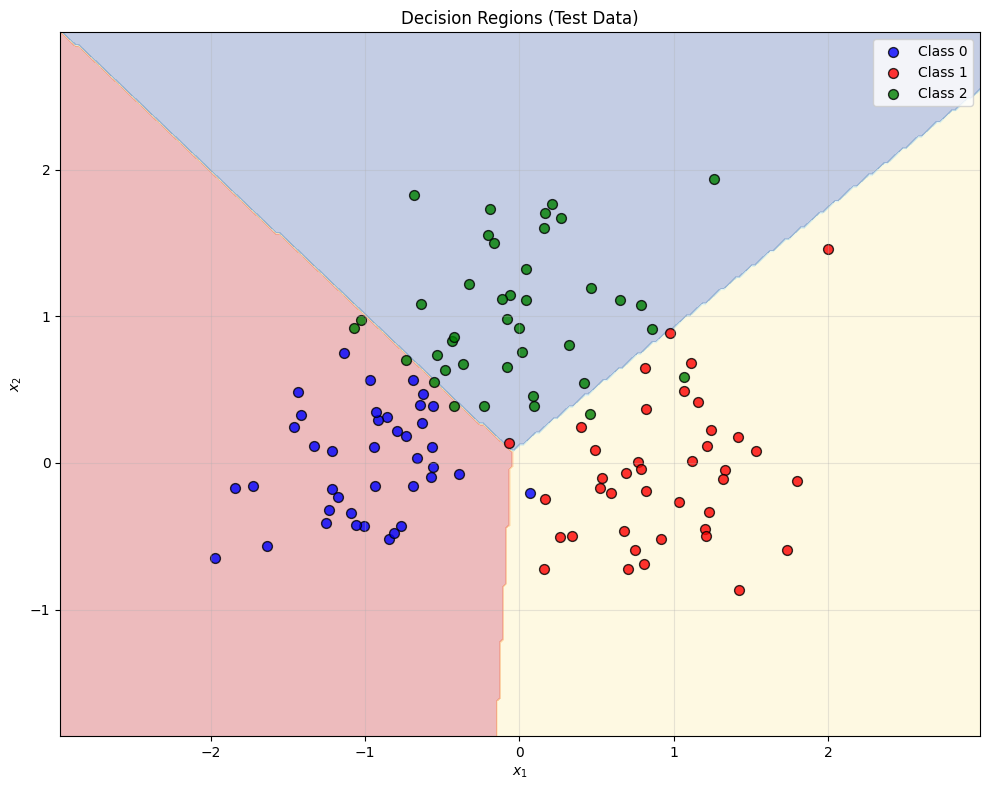

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support

def make_multiclass_data(n_per_class=200, seed=0):
    rng = np.random.default_rng(seed)

    # Three random center
    mu0 = np.array([-1.0, 0.0])
    mu1 = np.array([1.0, 0.0])
    mu2 = np.array([0.0, 1.0])

    # Shared covar
    Sigma = np.diag([0.5**2, 0.5**2])

    # Three Guassian clusters in R^2
    X0 = rng.multivariate_normal(mu0, Sigma, size=n_per_class)
    X1 = rng.multivariate_normal(mu1, Sigma, size=n_per_class)
    X2 = rng.multivariate_normal(mu2, Sigma, size=n_per_class)

    X = np.vstack([X0, X1, X2])
    t = np.hstack([np.zeros(n_per_class), np.ones(n_per_class), 2*np.ones(n_per_class)]).astype(int)

    return X, t

# Generate and plot data

X_train, t_train = make_multiclass_data(n_per_class=160, seed=0)
X_test, t_test = make_multiclass_data(n_per_class=40, seed=42)

# Plot data
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green']
for i in range(3):
    mask = (t_train == i)
    plt.scatter(X_train[mask, 0], X_train[mask, 1], c=colors[i], label = f'Class {i}', alpha=0.6, edgecolors='k')
plt.xlabel('$x_1$'); plt.ylabel('$x_2$')
plt.title('Training data - Three Guassian Clusters')
plt.legend(); plt.grid(True, alpha=0.3)
plt.axis('equal'); plt.tight_layout(); plt.show()

# Softmax Naive Implementation
def softmax_naive(A):
    expA = np.exp(A)
    return expA / np.sum(expA, axis=1, keepdims=True)


# Softmax function
def softmax_stable(A):
    A = A - np.max(A, axis=1, keepdims=True)
    expA = np.exp(A)
    return expA / np.sum(expA, axis=1, keepdims=True)

# Test softmax Stability
A_small = np.array([[1.0, 2.0, 3.0]])
print("\nSmall logits:", A_small)
print("Naive:  ", softmax_naive(A_small))
print("Stable: ", softmax_stable(A_small))

# Test with large logits - naive fails!
A_large = np.array([[1000.0, 1001.0, 1002.0]])
print("\nLarge logits:", A_large)
print("Naive:  ", softmax_naive(A_large), "Contains NaN/inf")
print("Stable: ", softmax_stable(A_large), "Working")


def log_softmax(A):
    A = A - np.max(A, axis=1, keepdims=True)
    logsumexp = np.log(np.sum(np.exp(A), axis=1, keepdims=True))
    return A - logsumexp # returns log y_{n,k}

A_test = np.array([[1.0, 2.0, 3.0], [0.5, 1.5, 2.5]])
print("\nLogits:\n", A_test)

Y_stable = softmax_stable(A_test)
logY_direct = np.log(Y_stable)
logY_stable = log_softmax(A_test)

print("\nlog(softmax(A)) - direct method:\n", logY_direct)
print("\nlog_softmax(A) - stable method:\n", logY_stable)
print("\nDifference (should be ~0):\n", np.abs(logY_direct - logY_stable))
print("Max difference:", np.max(np.abs(logY_direct - logY_stable)))

# Covert class labels into one-hot encoding
def one_hot_encode(t, K):
    N = len(t)
    T = np.zeros((N, K))
    T[np.arange(N), t] = 1
    return T

def loss_and_grad(W, b, X, T, use_logsumexp=False):
    """
    Compute loss and gradients for softmax regression.
    NLL: L(W,b) = -sum_{n,k} t_{n,k} log(y_{n,k})

    Gradients:
        grad_W L = (Y - T)^T @ X
        grad_b L = (Y - T)^T @ 1

    Args:
        W: (K, d) weight matrix
        b: (K,) bias vector
        X: (N, d) input data
        T: (N, K) one-hot encoded labels
        use_logsumexp: if True, use log-sum-exp trick
    """
    N, d = X.shape
    K = W.shape[0]

    # Forward pass
    A = X @ W.T + b

    if not use_logsumexp:
        # Stable softmax
        Y = softmax_stable(A) # (N, K)
        # Loss: -sum_{n,k} t_{n,k} log(y_{n,k})
        eps = 1e-12 # small constant to avoid log(0)
        L = -np.sum(T * np.log(Y + eps)) / N # average loss per sample
    else:
        # Log-sum-exp trick
        logY = log_softmax(A)
        L = -np.sum(T * logY) / N # average loss per sample
        Y = np.exp(logY) # (N, K)

    # Gradients
    diff = Y - T
    grad_W = diff.T @ X / N # (K, d)
    grad_b = np.sum(diff, axis=0) / N # (K,)

    return L, grad_W, grad_b


# Training softmax regression

def train_softmax(X_train, t_train, K, use_logsumexp=False, lr=0.5, epochs=200, verbose=False):
    N, d = X_train.shape

    # Params
    W = np.zeros((K, d))
    b = np.zeros(K)

    T = one_hot_encode(t_train, K)
    losses = []
    for epoch in range(epochs):
        L, grad_W, grad_b = loss_and_grad(W, b, X_train, T, use_logsumexp)

        # Gradient descent update
        W -= lr * grad_W
        b -= lr * grad_b
        losses.append(L)

        if verbose and (epoch % 50 == 0 or epoch == epochs - 1):
            print(f"Epoch {epoch:3d}: Loss = {L:.4f}")

    return W, b, losses

# Prediction
def predict_softmax(W, b, X):
    A = X @ W.T + b
    Y = softmax_stable(A)
    predictions = np.argmax(Y, axis=1)
    return Y, predictions

# Training with both logsumexp and Stable softmax
K = 3 # Number of classes

print("Training with Stable Softmax:")
W1, b1, losses1 = train_softmax(X_train, t_train, K, use_logsumexp=False, lr=0.5, epochs=200, verbose=True)

print({"Training with Log sum exp"})
W2, b2, losses2 = train_softmax(X_train, t_train, K, use_logsumexp=True, lr=0.5, epochs=200, verbose=True)

# Coparision

plt.figure(figsize=(10, 5))
plt.plot(losses1, 'b-', linewidth=2, label='Stable Softmax')
plt.plot(losses2, 'r--', linewidth=2, label='Log-Sum-Exp')
plt.xlabel('Epoch')
plt.ylabel('Loss (NLL)')
plt.title('Training Loss: Stable Softmax vs Log-Sum-Exp')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Final loss (stable):  {losses1[-1]:.6f}")
print(f"Final loss (logsumexp): {losses2[-1]:.6f}")
print(f"Difference: {abs(losses1[-1] - losses2[-1]):.2e}")
print(f"W difference: {np.max(np.abs(W1 - W2)):.2e}")
print(f"b difference: {np.max(np.abs(b1 - b2)):.2e}")

# Evaluation

W, b = W1, b1

# Test set predictions
Y_test, pred_test = predict_softmax(W, b, X_test)

# Metrics
acc = accuracy_score(t_test, pred_test)
conf_mat = confusion_matrix(t_test, pred_test)
precision, recall, f1, _ = precision_recall_fscore_support(t_test, pred_test, average=None, zero_division=0)

print(f"Accuracy: {acc:.4f}")
print("\nConfusion Matrix:")
print(conf_mat)
print("\nPer-class Metrics:")
for k in range(K):
    print(f"Class {k}: Precision={precision[k]:.3f}, Recall={recall[k]:.3f}, F1={f1[k]:.3f}")

# Plot confusion matrix
plt.figure(figsize=(6, 5))
plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(K)
plt.xticks(tick_marks, [f'Class {i}' for i in range(K)])
plt.yticks(tick_marks, [f'Class {i}' for i in range(K)])

# Add text annotations
for i in range(K):
    for j in range(K):
        plt.text(j, i, str(conf_mat[i, j]),
                ha="center", va="center",
                color="white" if conf_mat[i, j] > conf_mat.max() / 2 else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Plot decision boundaries
def plot_decision_regions(X, t, W, b, title="Decision Regions"):
    """Plot decision regions and data points"""
    plt.figure(figsize=(10, 8))

    # Create mesh
    h = 0.02
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, h),
                           np.arange(x2_min, x2_max, h))

    # Predict on mesh
    X_mesh = np.c_[xx1.ravel(), xx2.ravel()]
    _, Z = predict_softmax(W, b, X_mesh)
    Z = Z.reshape(xx1.shape)

    # Plot decision regions
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=plt.cm.RdYlBu)

    # Plot data points
    colors = ['blue', 'red', 'green']
    for k in range(3):
        mask = t == k
        plt.scatter(X[mask, 0], X[mask, 1],
                   c=colors[k], label=f'Class {k}',
                   alpha=0.8, edgecolors='k', s=50)

    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

plot_decision_regions(X_train, t_train, W, b, "Decision Regions (Training Data)")
plt.show()

plot_decision_regions(X_test, t_test, W, b, "Decision Regions (Test Data)")
plt.show()

# **Question 4**

Discussion:
In this assignment I implemented a manual autograd implementation and a module implementation of a MLP.
I learned that the Activation functions are important for the performance of the model.
I also learned that it has a fast initial learning, then it will plateau, all models reached 95%+ accuracy , then had a slight decrease in accuracy.
One challenge I faced was the backward pass, I forgot that I needed to do param.data -= lr * param.grad instead of param -= lr * param.grad.
Another challenge I had was that Sigmoid convergence took nearly twice as long as the others to reach 97% accuracy


Part A: Manual autograd implementation
Epoch 1/10 - Loss: 0.2784, Train Acc: 91.73%, Test Acc: 95.35%
Epoch 2/10 - Loss: 0.1355, Train Acc: 95.98%, Test Acc: 96.18%
Epoch 3/10 - Loss: 0.0993, Train Acc: 97.11%, Test Acc: 96.82%
Epoch 4/10 - Loss: 0.0787, Train Acc: 97.72%, Test Acc: 97.11%
Epoch 5/10 - Loss: 0.0660, Train Acc: 98.10%, Test Acc: 97.36%
Epoch 6/10 - Loss: 0.0550, Train Acc: 98.46%, Test Acc: 97.35%
Epoch 7/10 - Loss: 0.0473, Train Acc: 98.65%, Test Acc: 97.43%
Epoch 8/10 - Loss: 0.0412, Train Acc: 98.89%, Test Acc: 97.72%
Epoch 9/10 - Loss: 0.0357, Train Acc: 99.05%, Test Acc: 97.58%
Epoch 10/10 - Loss: 0.0313, Train Acc: 99.21%, Test Acc: 97.82%


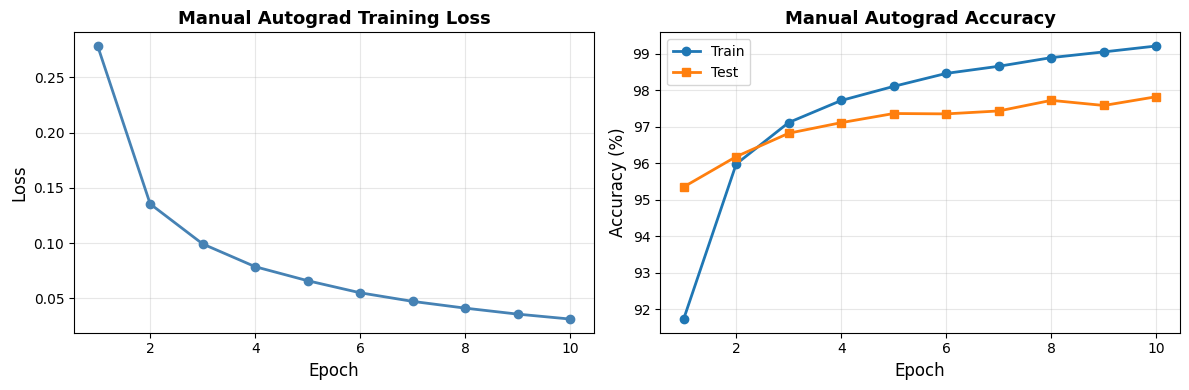

Part B: Module implementation
Epoch 1/10 - Loss: 0.3044, Train Acc: 91.22%, Test Acc: 95.23%
Epoch 2/10 - Loss: 0.1343, Train Acc: 96.02%, Test Acc: 96.75%
Epoch 3/10 - Loss: 0.0936, Train Acc: 97.16%, Test Acc: 97.03%
Epoch 4/10 - Loss: 0.0711, Train Acc: 97.86%, Test Acc: 97.54%
Epoch 5/10 - Loss: 0.0555, Train Acc: 98.23%, Test Acc: 97.58%
Epoch 6/10 - Loss: 0.0460, Train Acc: 98.56%, Test Acc: 97.63%
Epoch 7/10 - Loss: 0.0370, Train Acc: 98.84%, Test Acc: 97.52%
Epoch 8/10 - Loss: 0.0320, Train Acc: 98.99%, Test Acc: 97.90%
Epoch 9/10 - Loss: 0.0262, Train Acc: 99.21%, Test Acc: 97.77%
Epoch 10/10 - Loss: 0.0218, Train Acc: 99.34%, Test Acc: 97.93%


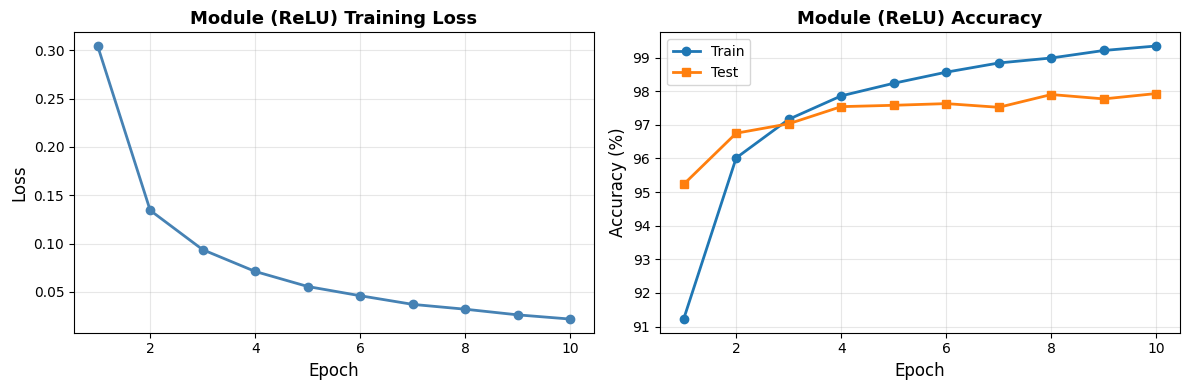

Part C: Compare activations
Training with relu activation function
Epoch 1/10 - Loss: 0.3087, Train Acc: 91.09%, Test Acc: 95.28%
Epoch 2/10 - Loss: 0.1368, Train Acc: 95.94%, Test Acc: 96.63%
Epoch 3/10 - Loss: 0.0961, Train Acc: 97.14%, Test Acc: 97.17%
Epoch 4/10 - Loss: 0.0730, Train Acc: 97.80%, Test Acc: 97.54%
Epoch 5/10 - Loss: 0.0582, Train Acc: 98.20%, Test Acc: 97.36%
Epoch 6/10 - Loss: 0.0464, Train Acc: 98.53%, Test Acc: 97.51%
Epoch 7/10 - Loss: 0.0375, Train Acc: 98.92%, Test Acc: 97.44%
Epoch 8/10 - Loss: 0.0309, Train Acc: 99.11%, Test Acc: 97.88%
Epoch 9/10 - Loss: 0.0260, Train Acc: 99.17%, Test Acc: 97.74%
Epoch 10/10 - Loss: 0.0231, Train Acc: 99.30%, Test Acc: 97.81%
Training with relu activation function completed
Training with tanh activation function
Epoch 1/10 - Loss: 0.3161, Train Acc: 91.20%, Test Acc: 94.74%
Epoch 2/10 - Loss: 0.1494, Train Acc: 95.78%, Test Acc: 96.13%
Epoch 3/10 - Loss: 0.1057, Train Acc: 97.04%, Test Acc: 96.95%
Epoch 4/10 - Loss: 0.0807

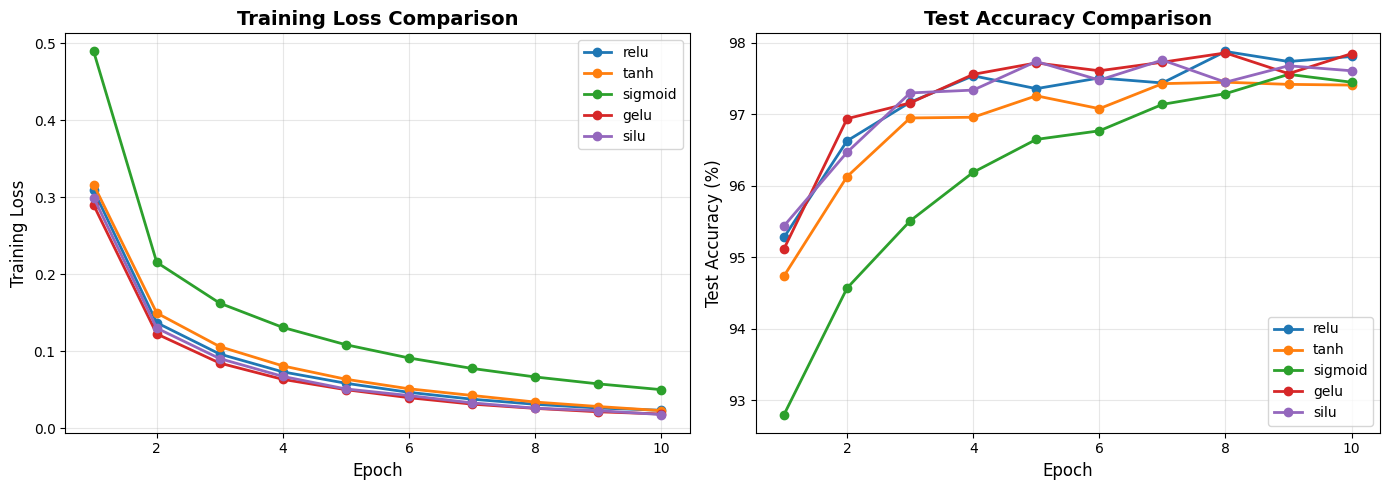

Activation   Final Test Accuracy 
-----------------------------------
relu          97.81%
tanh          97.41%
sigmoid       97.45%
gelu          97.85%
silu          97.61%
Part D: Detailed metrics
Accuracy:  97.93%
Precision: 0.9795
Recall:    0.9790
F1 Score:  0.9792


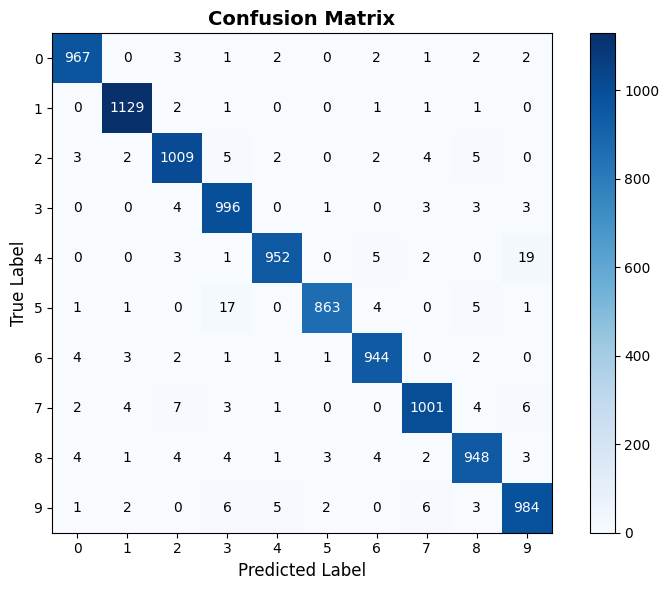

Part E: Plot decision regions on PCA(2D) of MNIST Test Set


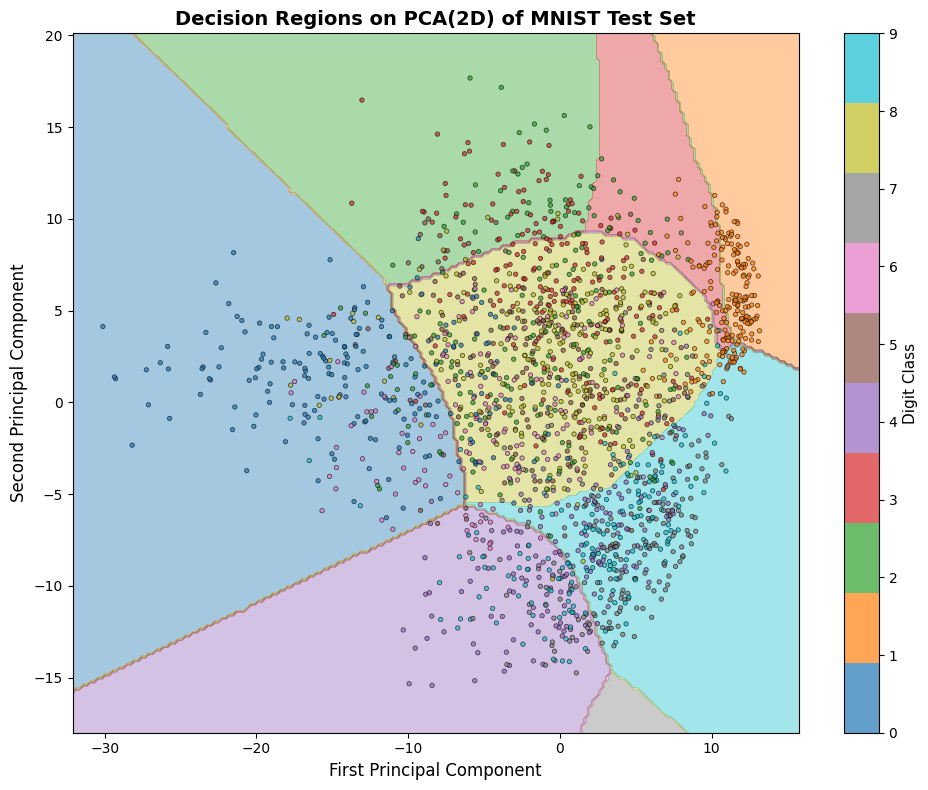

In [1]:
import torch, torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# MNIST
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_data = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST('./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=256, shuffle=False)

def get_activation(activation_name):
    """Return activation function by name"""
    activations = {
        'relu': F.relu,
        'tanh': torch.tanh,
        'sigmoid': torch.sigmoid,
        'gelu': F.gelu,
        'silu': F.silu
    }
    return activations[activation_name.lower()]

def init_params(d_in=784, d_h=128, d_out=10):
    # Xavier initialization
    W1 = (torch.randn(d_in, d_h) * np.sqrt(2.0 / d_in)).requires_grad_()
    b1 = torch.zeros(d_h, requires_grad=True)
    W2 = (torch.randn(d_h, d_out) * np.sqrt(2.0 / d_h)).requires_grad_()
    b2 = torch.zeros(d_out, requires_grad=True)

    return [W1, b1, W2, b2]



# Part A: Manual autograd
def forward(X, params, activation):
    W1, b1, W2, b2 = params
    z1 = X @ W1 + b1
    # TODO: apply activation g(z1)
    # TODO: compute logits (no softmax)

    act_func = get_activation(activation)
    h = act_func(z1)
    logits = h @ W2 + b2

    return logits


def train_manual(train_loader, test_loader, lr=0.1, epochs=10, activation='relu'):
    # TODO: initialize params with requires_grad=True
    # TODO: forward pass, cross-entropy loss, backward(), manual update
    # TODO: track training/validation accuracy
    params = init_params()

    train_losses = []
    train_accs = []
    test_accs = []

    for epoch in range(epochs):
        epoch_loss = 0
        correct = 0
        total = 0

        for X_batch, t_batch in train_loader:
            # Flatten the input
            X_batch = X_batch.view(X_batch.size(0), -1)

            # Forward pass
            logits = forward(X_batch, params, activation)

            # Cross entropy
            loss = F.cross_entropy(logits, t_batch)

            # Backward pass
            loss.backward()

            with torch.no_grad():
                for param in params:
                    param.data -= lr * param.grad
                    param.grad.zero_()

            # Track metric
            epoch_loss += loss.item()
            pred = logits.argmax(dim=1)
            correct += (pred == t_batch).sum().item()
            total += t_batch.size(0)

        avg_loss = epoch_loss / len(train_loader)
        train_acc = 100 * correct / total

        # Evaluate on test set
        test_acc = evaluate_manual(test_loader, params, activation)

        train_losses.append(avg_loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)

        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%")

    return params, train_losses, train_accs, test_accs

def evaluate_manual(test_loader, params, activation):

    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, t_batch in test_loader:
            X_batch = X_batch.view(X_batch.size(0), -1)
            logits = forward(X_batch, params, activation)
            pred = logits.argmax(dim=1)
            correct += (pred == t_batch).sum().item()
            total += t_batch.size(0)

    return 100 * correct / total

class MLP(nn.Module):
    def __init__(self, d_in=784, d_h=128, d_out=10, activation='relu'):
        super().__init__()
        self.fc1 = nn.Linear(d_in, d_h)
        self.fc2 = nn.Linear(d_h, d_out)
        self.activation = activation

    def forward(self, x):
        x = x.view(x.size(0), -1)
        # TODO: apply chosen activation; return raw logits
        x = x.view(x.size(0), -1)

        # Apply first layer and activation
        x = self.fc1(x)
        act_func = get_activation(self.activation)
        x = act_func(x)

        # Apply second layer
        logits = self.fc2(x)

        return logits

def evaluate_module(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for X_batch, t_batch in test_loader:
            logits = model(X_batch)
            pred = logits.argmax(dim=1)
            correct += (pred == t_batch).sum().item()
            total += t_batch.size(0)
            all_preds.append(pred.cpu())
            all_targets.append(t_batch.cpu())
    return 100 * correct / total

def train_module(model, train_loader, test_loader, lr=1e-3, epochs=10):
    # TODO: optimizer (Adam/SGD), loss (F.cross_entropy)
    # TODO: training loop with evaluation; store metrics/curves
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    train_accs = []
    test_accs = []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        correct = 0
        total = 0

        for X_batch, t_batch in train_loader:
            optimizer.zero_grad()

            # Forward pass
            logits = model(X_batch)

            # Cross entropy
            loss = F.cross_entropy(logits, t_batch)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Track metric
            epoch_loss += loss.item()
            pred = logits.argmax(dim=1)
            correct += (pred == t_batch).sum().item()
            total += t_batch.size(0)

        avg_loss = epoch_loss / len(train_loader)
        train_acc = 100 * correct / total

        # Evaluate on test set
        test_acc = evaluate_module(model, test_loader)

        train_losses.append(avg_loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)

        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%")

    return model, train_losses, train_accs, test_accs

# Compare activations functions

def compare_activations():
    activations = ['relu', 'tanh', 'sigmoid', 'gelu', 'silu']
    results = {}
    for activation in activations:
        print(f"Training with {activation} activation function")
        model, train_losses, train_accs, test_accs = train_module(MLP(activation=activation), train_loader, test_loader, lr=1e-3, epochs=10)
        print(f"Training with {activation} activation function completed")

        results[activation] = {
            "model": model,
            "train_loss": train_losses,
            "train_acc": train_accs,
            "test_acc": test_accs
        }

    return results

# Plot results

def plot_training_curves(results_dict):
    """Plot loss and accuracy for multiple activations"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    for act_name, data in results_dict.items():
        epochs = range(1, len(data['train_loss']) + 1)
        ax1.plot(epochs, data['train_loss'], marker='o', label=act_name, linewidth=2)
        ax2.plot(epochs, data['test_acc'], marker='o', label=act_name, linewidth=2)

    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Training Loss', fontsize=12)
    ax1.set_title('Training Loss Comparison', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)

    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Test Accuracy (%)', fontsize=12)
    ax2.set_title('Test Accuracy Comparison', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_single_model_curves(train_losses, train_accs, test_accs, title_prefix=""):
    """Plot training curves for a single model"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    epochs = range(1, len(train_losses) + 1)

    ax1.plot(epochs, train_losses, marker='o', linewidth=2, color='steelblue')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title(f'{title_prefix} Training Loss', fontsize=13, fontweight='bold')
    ax1.grid(True, alpha=0.3)

    ax2.plot(epochs, train_accs, marker='o', label='Train', linewidth=2)
    ax2.plot(epochs, test_accs, marker='s', label='Test', linewidth=2)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy (%)', fontsize=12)
    ax2.set_title(f'{title_prefix} Accuracy', fontsize=13, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Compute Metrics

def compute_metrics(model):
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for X_batch, t_batch in test_loader:
            logits = model(X_batch)
            pred = logits.argmax(dim=1).cpu().numpy()
            all_preds.append(pred)
            all_targets.append(t_batch.cpu().numpy())
    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_targets)

    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="macro")
    conf_mat = confusion_matrix(y_true, y_pred)

    print(f"Accuracy:  {acc*100:.2f}%")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print("="*60)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_mat, cmap="Blues", interpolation='nearest')
    plt.title("Confusion Matrix", fontsize=14, fontweight='bold')
    plt.colorbar()

    # Add text annotations
    thresh = conf_mat.max() / 2
    for i in range(10):
        for j in range(10):
            plt.text(j, i, str(conf_mat[i, j]),
                    ha="center", va="center",
                    color="white" if conf_mat[i, j] > thresh else "black")

    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.xticks(range(10))
    plt.yticks(range(10))
    plt.tight_layout()
    plt.show()

    return acc, prec, rec, f1

# Plotting 2D PCA of the test set

def pca_2d(X, n_components=2):
    # X: (N, D)
    X = X - X.mean(axis=0, keepdims=True)
    U, S, Vt = np.linalg.svd(X, full_matrices=False)
    Z = X @ Vt[:n_components].T
    return Z, Vt[:n_components]

def plot_decision_regions_pca(model):
    model.eval()

    X_list = []
    y_list = []

    for X_batch, t_batch in test_loader:
        X_list.append(X_batch.view(X_batch.size(0), -1).numpy())
        y_list.append(t_batch.numpy())

    X_all = np.vstack(X_list)
    y_all = np.hstack(y_list)

    Z, Wpca = pca_2d(X_all, n_components=2)

    # Build a meshgrid
    x_min, x_max = Z[:,0].min()-2, Z[:,0].max()+2
    y_min, y_max = Z[:,1].min()-2, Z[:,1].max()+2
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
    grid_pca = np.column_stack([xx.ravel(), yy.ravel()])  # (M, 2)

    X_mean = X_all.mean(axis=0, keepdims=True)
    X_grid = grid_pca @ Wpca + X_mean

    with torch.no_grad():
        X_grid_t = torch.from_numpy(X_grid).float()
        logits = model(X_grid_t)
        pred = logits.argmax(dim=1).cpu().numpy()

    pred_img = pred.reshape(xx.shape)

    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, pred_img, alpha=0.4, levels=np.arange(-0.5, 10.5, 1), cmap="tab10")

    # Subsample points for clearer visualization
    subsample = np.random.choice(len(Z), size=2000, replace=False)
    plt.scatter(Z[subsample, 0], Z[subsample, 1], c=y_all[subsample],
                s=10, cmap="tab10", edgecolor='k', linewidth=0.5, alpha=0.7)

    plt.title("Decision Regions on PCA(2D) of MNIST Test Set", fontsize=14, fontweight='bold')
    plt.xlabel("First Principal Component", fontsize=12)
    plt.ylabel("Second Principal Component", fontsize=12)

    # Add colorbar
    cbar = plt.colorbar(ticks=range(10))
    cbar.set_label('Digit Class', fontsize=11)

    plt.tight_layout()
    plt.show()


# Main function
if __name__ == "__main__":
    print("Part A: Manual autograd implementation")

    params, train_losses, train_accs, test_accs = train_manual(train_loader, test_loader, activation='relu', lr=0.1, epochs=10)
    plot_single_model_curves(train_losses, train_accs, test_accs, title_prefix="Manual Autograd")

    print("Part B: Module implementation")

    model_relu, train_losses_relu, train_accs_relu, test_accs_relu = train_module(MLP(activation='relu'), train_loader, test_loader, lr=1e-3, epochs=10)
    plot_single_model_curves(train_losses_relu, train_accs_relu, test_accs_relu, title_prefix="Module (ReLU)")

    print("Part C: Compare activations")
    results = compare_activations()

    # Plot comparison of training curves
    plot_training_curves(results)

    print("="*70)
    print(f"{'Activation':<12} {'Final Test Accuracy':<20}")
    print("-"*35)
    for act, data in results.items():
        final_acc = data['test_acc'][-1]
        print(f"{act:<12} {final_acc:>6.2f}%")
    print("="*70)

    print("Part D: Detailed metrics")
    compute_metrics(model_relu)

    print("Part E: Plot decision regions on PCA(2D) of MNIST Test Set")
    plot_decision_regions_pca(model_relu)


# **Question 5**

Discussion:
In this assignment I implemented the gradient descent methods and plotted the surface and paths.
I learned that the gradient descent methods are important for the optimization of the model.
I also learned that the momentum method is a good way to speed up the convergence of the model.
One challenge I faced was the implementation of the Nesterov method, I had to look at the equation to understand it.
Another challenge I had was the implementation of the RMSProp method, I had to look at the equation to understand it.


Running optimization algorithms...
Starting point: w0 = [1.8 1.8]
Initial error: E(w0) = 17.999149

Final Results:
------------------------------------------------------------
Batch GD    : w_final = [ 0.0914, -0.0250], E = 0.001215
Momentum    : w_final = [ 0.0146, -0.0061], E = 0.000053
Nesterov    : w_final = [ 0.0032, -0.0009], E = 0.000001
RMSProp     : w_final = [ 0.8150,  0.7754], E = 3.478740
Adam        : w_final = [ 0.8491,  0.8958], E = 4.446550


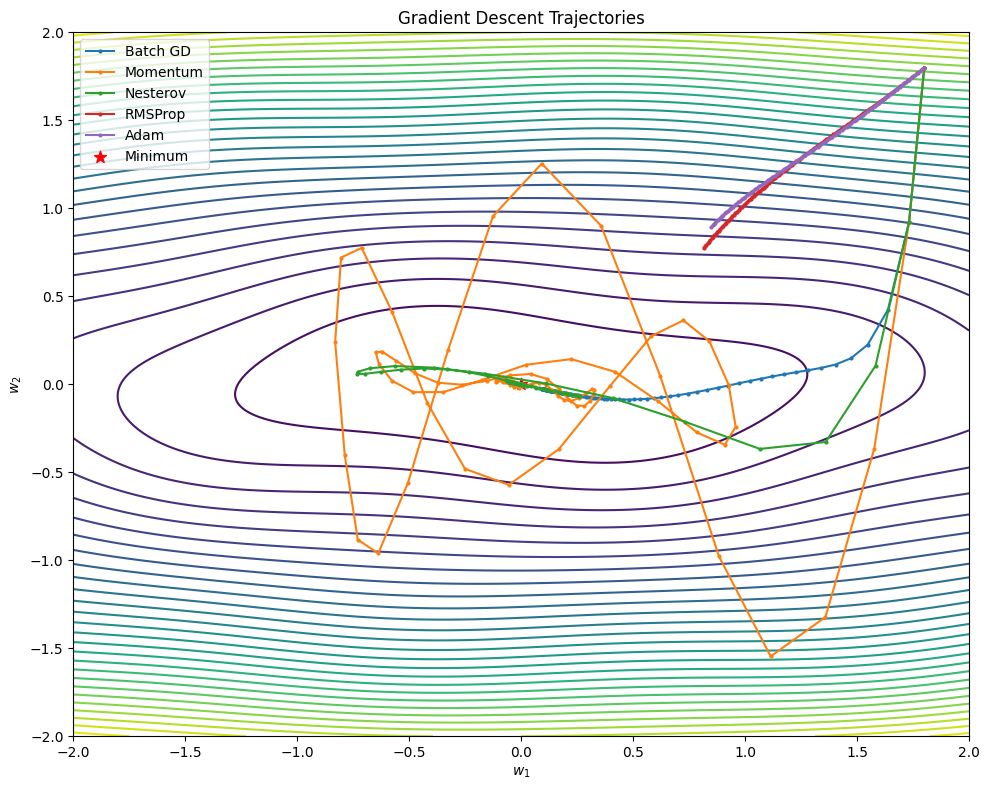

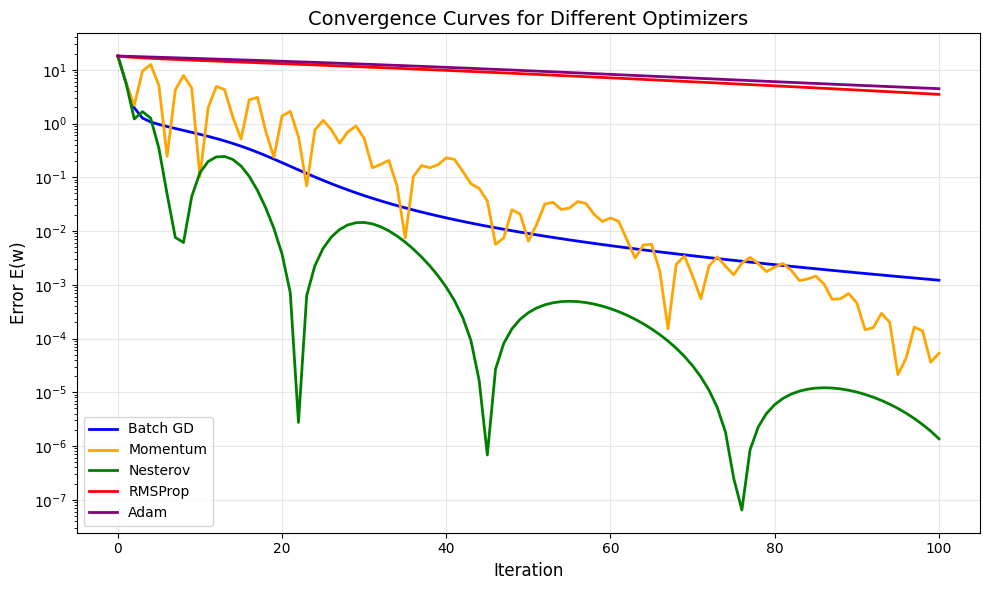

In [ ]:
import numpy as np, matplotlib.pyplot as plt
from torch.func import grad

a, b = 1.0, 10.0

def E(w):
    w1, w2 = w
    return 0.5*(a*w1**2 + b*w2**2) + 0.3*np.sin(3*w1)*np.sin(3*w2)

def gradE(w):
    w1, w2 = w
    g1 = a*w1 + 0.9*np.cos(3*w1)*np.sin(3*w2)
    g2 = b*w2 + 0.9*np.sin(3*w1)*np.cos(3*w2)
    return np.array([g1, g2])

def gradient_descent(w0, gradf, lr=0.05, steps=100):
    w = w0.copy(); traj = [w.copy()]
    for _ in range(steps):
        w -= lr * gradf(w); traj.append(w.copy())
    return np.array(traj)

def momentum(w0, gradf, lr=0.05, mu=0.9, steps=100):
    # TODO: Eq. (7.31)
    """
    v(t) = mu * v(t - 1) -lr * grad
    w(t) = w(t - 1) + v(t)
    """

    w = w0.copy()
    v = np.zeros_like(w)
    traj = [w.copy()]

    for _ in range(steps):
        g = gradf(w)
        v = mu * v - lr * g
        w = w + v
        traj.append(w.copy())
    return np.array(traj)

def nesterov(w0, gradf, lr=0.05, mu=0.9, steps=100):
    # TODO: Eq. (7.34)
    """
    Look ahead: compute gradient at w + mu*v
    v(t) = mu * v(t-1) - lr * grad(w + mu*v)
    w(t) = w(t-1) + v(t)
    """
    w = w0.copy()
    v = np.zeros_like(w)
    traj = [w.copy()]

    for _ in range(steps):
        # Gradient at lookahead position
        g = gradf(w + mu * v)
        v = mu * v - lr * g
        w = w + v
        traj.append(w.copy())

    return np.array(traj)

def rmsprop(w0, gradf, lr=0.01, beta=0.9, eps=1e-8, steps=100):
    # TODO: Eq. (7.41)
    """
    r(t) = beta * r(t-1) + (1-beta) * grad^2
    w(t) = w(t-1) - lr * grad / sqrt(r(t) + eps)
    """

    w = w0.copy()
    r = np.zeros_like(w)
    traj = [w.copy()]

    for _ in range(steps):
        g = gradf(w)
        r = beta * r + (1 - beta) * g**2
        w = w - lr * g / (np.sqrt(r) + eps)
        traj.append(w.copy())

    return np.array(traj)


def adam(w0, gradf, lr=0.01, beta1=0.9, beta2=0.99, eps=1e-8, steps=100):
    # TODO: Eqs. (7.43)(7.47)
    """
    m(t) = beta1 * m(t-1) + (1-beta1) * grad
    v(t) = beta2 * v(t-1) + (1-beta2) * grad^2
    m_hat = m(t) / (1 - beta1^t)
    v_hat = v(t) / (1 - beta2^t)
    w(t) = w(t-1) - lr * m_hat / (sqrt(v_hat) + eps)
    """
    w = w0.copy()
    m = np.zeros_like(w)
    v = np.zeros_like(w)
    traj = [w.copy()]

    for t in range(1, steps + 1):
        g = gradf(w)

        # Update biased first and second moments
        m = beta1 * m + (1 - beta1) * g
        v = beta2 * v + (1 - beta2) * g**2

        # Bias correction
        m_hat = m / (1 - beta1**t)
        v_hat = v / (1 - beta2**t)

        # Update parameters
        w = w - lr * m_hat / (np.sqrt(v_hat) + eps)
        traj.append(w.copy())

    return np.array(traj)

# Plot surface and paths
def plot_surface_and_paths(paths, labels):
    w1 = np.linspace(-2, 2, 400)
    w2 = np.linspace(-2, 2, 400)
    W1, W2 = np.meshgrid(w1, w2)
    Z = E([W1, W2])

    plt.figure(figsize=(10,8))
    plt.contour(W1, W2, Z, levels=30, cmap='viridis')
    for p, lbl in zip(paths, labels):
        plt.plot(p[:,0], p[:,1], marker='o', markersize=2, label=lbl)
    plt.scatter([0],[0], marker='*', c='red', s=80, label='Minimum')
    plt.legend(); plt.xlabel('$w_1$'); plt.ylabel('$w_2$')
    plt.title('Gradient Descent Trajectories'); plt.tight_layout(); plt.show()

# Plot convergence curves
def plot_convergence_curves(paths, labels):

    plt.figure(figsize=(10, 6))

    colors = ['blue', 'orange', 'green', 'red', 'purple']
    for i, (path, lbl) in enumerate(zip(paths, labels)):
        errors = [E(w) for w in path]
        plt.plot(errors, label=lbl, color=colors[i % len(colors)], linewidth=2)

    plt.xlabel('Iteration', fontsize=12)
    plt.ylabel('Error E(w)', fontsize=12)
    plt.title('Convergence Curves for Different Optimizers', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    plt.tight_layout()
    plt.show()

w0 = np.array([1.8, 1.8])
steps = 100

print("Running optimization algorithms...")
print(f"Starting point: w0 = {w0}")
print(f"Initial error: E(w0) = {E(w0):.6f}\n")

# Run all methods
traj_gd = gradient_descent(w0, gradE, lr=0.05, steps=steps)
traj_momentum = momentum(w0, gradE, lr=0.05, mu=0.9, steps=steps)
traj_nesterov = nesterov(w0, gradE, lr=0.05, mu=0.9, steps=steps)
traj_rmsprop = rmsprop(w0, gradE, lr=0.01, beta=0.9, steps=steps)
traj_adam = adam(w0, gradE, lr=0.01, beta1=0.9, beta2=0.99, steps=steps)

paths = [traj_gd, traj_momentum, traj_nesterov, traj_rmsprop, traj_adam]
labels = ['Batch GD', 'Momentum', 'Nesterov', 'RMSProp', 'Adam']

# Print final results
print("Final Results:")
print("-" * 60)
for path, label in zip(paths, labels):
    final_w = path[-1]
    final_error = E(final_w)
    print(f"{label:12s}: w_final = [{final_w[0]:7.4f}, {final_w[1]:7.4f}], "
          f"E = {final_error:.6f}")

plot_surface_and_paths(paths, labels)
plot_convergence_curves(paths, labels)